### Contents

- [Header](#Header)
- [Import Data](#Import-Data)
- [Functions](#Functions)


- [Pre-process Data](#Pre-process-Data)
- [Plot df_model](#Plot-df_model)


- [Create Features and Target](#Create-Features-and-Target)
- [Handle Imbalanced Data](#Handle-Imbalanced-Data)


- [Logistic Regression Model](#Logistic-Regression-Model)
- [KNN Model](#KNN-Model)
- [DTC Model](#DTC-Model)
- [RTC Model](#RTC-Model)
- [SVC Model](#SVC-Model)
- [GridSearch Model](#GridSearch-Model)

### Header

In [1]:
# import libraries

# maths
import numpy as np
import pandas as pd

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydotplus

# modelling
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix,accuracy_score,r2_score,mean_squared_error,cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.externals.six import StringIO
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Others
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# file paths

raw_path = '../../data/0_raw/fitrec/' 
input_path = '../../data/1_input/fitrec/'
clean_path = '../../data/2_clean/fitrec/' 
preprocess_path = '../../data/3_preprocess/fitrec/' 
output_path = '../../data/4_output/fitrec/'

sports_path = '../../data/1_input/sports/' 

### Import Data

In [3]:
# import data

#file = 'endomondoHR_proper_summary.csv'
#file = 'endomondoHR_proper_dist_spd_summary.csv'
file = 'endomondoHR_proper_dist_spd_time_summary.csv'

in_path = clean_path + file

df = pd.read_csv(in_path)

In [4]:
# import sports.xlsx

path = sports_path + 'sports.xlsx'
df_sports = pd.read_excel(path)
df_sports

,sport,sport_rename,type,venue,location_valid,distance_valid,speed_valid,speed_max
0,aerobics,aerobics,gym,indoor,0,0,0,0
1,badminton,badminton,racket,indoor,0,1,0,0
2,basketball,basketball,team,outdoor/indoor,1,1,0,0
3,bike,bike,aerobic,outdoor,1,1,1,244
4,bike (transport),bike,aerobic,outdoor,1,1,1,244
5,indoor cycling,bike,aerobic,indoor,0,1,1,244
6,mountain bike,bike,aerobic,outdoor,1,1,1,244
7,circuit training,circuit training,aerobic,outdoor/indoor,0,0,0,0
8,climbing,climbing,aerobic,outdoor/indoor,1,0,0,0
9,core stability training,core stability training,indoor,indoor,0,0,0,0


### Functions

### Pre-process Data

In [5]:
df.columns

Index(['id', 'userId', 'gender', 'sport', 'url', 'time_start', 'time_end',
       'time_dur', 'lat_start', 'lon_start', 'lat_end', 'lon_end', 'alt_avg',
       'alt_min', 'alt_05', 'alt_25', 'alt_75', 'alt_95', 'alt_max', 'hr_avg',
       'hr_min', 'hr_05', 'hr_25', 'hr_75', 'hr_95', 'hr_max', 'hr_outof',
       'hr_fatburn', 'hr_cardio', 'hr_peak', 'spd_avg', 'spd_min', 'spd_05',
       'spd_25', 'spd_75', 'spd_95', 'spd_max', 'impute'],
      dtype='object')

In [6]:
# remove rows with abnormal heartrate

print(len(df))

cond_1 = df['hr_min'] > 40
cond_2 = df['hr_avg'] > 50
cond_3 = df['hr_max'] > 60

df = df[cond_1 & cond_2 & cond_3]

print(len(df))

167783
167017


In [7]:
# remove rows with abnormal workout duration

print(len(df))

# time_dur in minutes
time_dur_mask = df['time_dur'] < 24 * 60
df = df[time_dur_mask]

print(len(df))

167017
167013


In [8]:
# drop rows if speed is nan

# print(len(df))
# df.dropna(subset=['spd_avg'],inplace=True)
# print(len(df))

In [9]:
df['sport'].value_counts()

bike                       71577
run                        70389
mountain bike              10703
bike (transport)            7653
indoor cycling              1689
walk                        1245
orienteering                 866
cross-country skiing         786
core stability training      445
fitness walking              292
skate                        257
roller skiing                238
hiking                       237
kayaking                      92
circuit training              89
weight training               74
rowing                        71
gymnastics                    66
soccer                        51
downhill skiing               42
treadmill running             28
snowshoeing                   16
swimming                      14
golf                          12
elliptical                    10
horseback riding              10
badminton                     10
basketball                     8
tennis                         8
aerobics                       7
climbing  

In [10]:
# select only sports with speed_valid = 1

valid_mask = df_sports['speed_valid'] == 1
valid_sport_list = df_sports[valid_mask]['sport']
valid_sport_list = list(valid_sport_list)

# overwrite: compare specific sports
#valid_sport_list = ['kayaking','rowing']

valid_mask_2 = df['sport'].isin(valid_sport_list)
df = df[valid_mask_2]
df['sport'].unique()

array(['bike', 'bike (transport)', 'run', 'mountain bike', 'rowing',
       'orienteering', 'kayaking', 'indoor cycling', 'skate',
       'cross-country skiing', 'walk', 'hiking', 'treadmill running',
       'swimming', 'snowshoeing', 'snowboarding', 'fitness walking',
       'roller skiing', 'horseback riding', 'downhill skiing',
       'treadmill walking', 'sailing', 'kite surfing', 'windsurfing'],
      dtype=object)

In [11]:
# merge similar sports

for idx,row in df_sports.iterrows():
    
    sport = row['sport'].rstrip()
    sport_rename = row['sport_rename']
    print(sport,sport_rename)
    
    df['sport'].replace(sport,sport_rename,inplace=True)

aerobics aerobics
badminton badminton
basketball basketball
bike bike
bike (transport) bike
indoor cycling bike
mountain bike bike
circuit training circuit training
climbing climbing
core stability training core stability training
elliptical elliptical
golf golf
gymnastics gymnastics
hiking hiking
horseback riding horseback riding
kayaking kayaking
martial arts martial arts
orienteering orienteering
rowing rowing       
rugby rugby
run run
treadmill running run
sailing sailing
skate skate
cross-country skiing skiing
downhill skiing skiing
roller skiing skiing
snowboarding snowboarding
snowshoeing snowshoeing
soccer soccer
squash squash
stair climing stair climbing
kite surfing surfing
windsurfing surfing
swimming swimming
table tennis table tennis
tennis tennis
fitness walking walk
treadmill walking walk
walk walk
weight training weight training
pilates yoga
yoga yoga


In [12]:
# merge similar sports

# df['sport'].replace('treadmill running','run',inplace=True)
# df['sport'].replace(['treadmill walking','fitness walking'],'walk',inplace=True)
# df['sport'].replace(['bike','mountain bike','bike (transport)','indoor cycling'],'cycle',inplace=True)
# df['sport'].replace(['windsurfing','kite surfing'],'surfing',inplace=True)
# df['sport'].replace(['cross-country skiing','downhill skiing','roller skiing'],'skiing',inplace=True)
# df['sport'].replace('pilates','yoga',inplace=True)

In [13]:
df['sport'].value_counts()

bike                91622
run                 70417
walk                 1538
skiing               1066
orienteering          866
skate                 257
hiking                237
kayaking               92
rowing                 71
snowshoeing            16
swimming               14
horseback riding       10
snowboarding            3
surfing                 2
sailing                 1
Name: sport, dtype: int64

In [14]:
# select columns for feature selection

# cols = ['sport', 'time_dur', 'alt_avg', 'alt_min', 'alt_25', 'alt_75','alt_max', 'hr_avg', 'hr_min', 'hr_25', 'hr_75', 'hr_max']

#cols = ['sport','hr_avg', 'hr_min', 'hr_25', 'hr_75', 'hr_max']
#cols = ['sport','hr_avg', 'hr_min', 'hr_05', 'hr_25', 'hr_75', 'hr_95','hr_max']
#cols = ['sport','hr_avg', 'hr_min', 'hr_25', 'hr_75', 'hr_max','spd_avg']
#cols = ['sport','hr_avg', 'hr_min', 'hr_25', 'hr_75', 'hr_max','spd_avg', 'spd_min', 'spd_25', 'spd_75', 'spd_max']

#cols = ['sport','spd_avg']
#cols = ['sport','spd_avg','spd_95']
#cols = ['sport','spd_avg', 'spd_05', 'spd_25', 'spd_75','spd_95']

#cols = ['sport','hr_outof', 'hr_fatburn', 'hr_cardio', 'hr_peak']
#cols = ['sport','hr_outof', 'hr_fatburn', 'hr_cardio', 'hr_peak','spd_avg']
#cols = ['sport','hr_outof', 'hr_fatburn', 'hr_cardio', 'hr_peak','spd_95']
cols = ['sport','hr_outof', 'hr_fatburn', 'hr_cardio', 'hr_peak','spd_avg','spd_95']
#cols = ['sport','hr_outof', 'hr_fatburn', 'hr_cardio', 'hr_peak','spd_avg','spd_25','spd_75']
#cols = ['sport','hr_outof', 'hr_fatburn', 'hr_cardio', 'hr_peak','spd_avg', 'spd_min', 'spd_25', 'spd_75', 'spd_max']

df_model = df[cols]

In [15]:
# add altitude feature

df_model['alt_diff'] = df['alt_max'] - df['alt_min']

In [16]:
# select only sports with minimal rows

count = df_model['sport'].value_counts()

#count_cond = count[count > 1].indexkn
#count_cond = count[count >= 5].inde
#count_cond = count[count >= 10].index
count_cond = count[count >= 50].index
#count_cond = count[count >= 70].index
#count_cond = count[count >= 100].index
#count_cond = count[count >= 200].index
#count_cond = count[count >= 800].index
#count_cond = count[count >= 1500].index
#count_cond = count[count >= 70000].index

count_mask = df_model['sport'].isin(count_cond)
df_model = df_model[count_mask]

In [17]:
print(df_model.shape)
df_model.head()

(166166, 8)


,sport,hr_outof,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95,alt_diff
0,bike,0.0,0.008026,0.507878,0.484096,26.152328,41.02704,56.6
1,bike,0.0,0.011256,0.612177,0.376567,27.636272,43.17102,50.6
2,bike,0.0,0.085785,0.790413,0.123802,26.159896,39.83040,57.6
3,bike,0.0,0.031234,0.674708,0.294058,27.135904,42.42096,51.6
4,bike,0.0,0.005738,0.076230,0.918033,31.241183,46.51405,28.0


In [18]:
df_model['sport'].value_counts()

bike             91622
run              70417
walk              1538
skiing            1066
orienteering       866
skate              257
hiking             237
kayaking            92
rowing              71
Name: sport, dtype: int64

### Plot df_model

In [19]:
# order = df_model.groupby('sport')['hr_max'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_max',y='sport',order=order);

In [20]:
# order = df_model.groupby('sport')['hr_avg'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_avg',y='sport',order=order);

In [21]:
# order = df_model.groupby('sport')['hr_min'].median().sort_values(ascending=False).index

# plt.figure(figsize=(20,15))
# #plt.xlim(0,300)

# sns.boxplot(data=df_model,x='hr_min',y='sport',order=order);

### Create Features and Target

In [22]:
df_model.head()

,sport,hr_outof,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95,alt_diff
0,bike,0.0,0.008026,0.507878,0.484096,26.152328,41.02704,56.6
1,bike,0.0,0.011256,0.612177,0.376567,27.636272,43.17102,50.6
2,bike,0.0,0.085785,0.790413,0.123802,26.159896,39.83040,57.6
3,bike,0.0,0.031234,0.674708,0.294058,27.135904,42.42096,51.6
4,bike,0.0,0.005738,0.076230,0.918033,31.241183,46.51405,28.0


In [23]:
# doing scaling and encoding before create X and y

cols = df_model.columns[1:]

ss = StandardScaler()
df_model[cols] = ss.fit_transform(df_model[cols])

le = LabelEncoder()
df_model['sport'] = le.fit_transform(df_model['sport'])

In [24]:
# create feature and target. next perform train_test_split

X = df_model.drop(columns='sport')
y = df_model['sport']

#le = LabelEncoder()
#y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,stratify=y,random_state=3050)

In [25]:
# ss = StandardScaler()
# ss.fit(X_train)

# X_train = ss.transform(X_train)
# X_test = ss.transform(X_test)

In [26]:
df_model.head()

,sport,hr_outof,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95,alt_diff
0,0,-0.31594,-0.757213,0.108813,0.660083,0.944302,1.180801,-0.191744
1,0,-0.31594,-0.745820,0.437208,0.321614,1.120523,1.346302,-0.240417
2,0,-0.31594,-0.482919,0.998399,-0.474012,0.945200,1.088428,-0.183632
3,0,-0.31594,-0.675347,0.634092,0.061902,1.061103,1.288402,-0.232305
4,0,-0.31594,-0.765286,-1.250264,2.025980,1.548612,1.604362,-0.423749


### Handle Imbalanced Data

In [27]:
# check before upsample/downsample

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(116316, 7)
(49850, 7)
(116316,)
(49850,)


In [28]:
# check before upsample/downsample

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 64135, 1: 166, 2: 64, 3: 606, 4: 50, 5: 49292, 6: 180, 7: 746, 8: 1077}

In [29]:
# sm = SMOTE(random_state=3050)
# X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [30]:
# get majority class index and row count

# sport_counts = df_model['sport'].value_counts()
# print(sport_counts)

# major_class_index = sport_counts.index[0]
# major_class_count = sport_counts.values[0]
# print(major_class_index,major_class_count)

In [31]:
# concatenate our training data back together

Xy_train = pd.concat([X_train, y_train], axis=1)

sport_counts = Xy_train['sport'].value_counts()
print(sport_counts)

print(Xy_train.shape)
Xy_train.head()

0    64135
5    49292
8     1077
7      746
3      606
6      180
1      166
2       64
4       50
Name: sport, dtype: int64
(116316, 8)


,hr_outof,hr_fatburn,hr_cardio,hr_peak,spd_avg,spd_95,alt_diff,sport
51326,-0.315940,-0.618521,1.509233,-0.863701,-1.294326,-1.354313,-0.560032,5
137700,-0.315940,-0.606767,1.498742,-0.863701,-0.867180,-1.037832,-0.561873,5
9228,-0.315940,0.859194,-0.250768,-0.422803,0.936829,0.847311,0.853090,0
160851,-0.266691,0.926677,0.115490,-0.863701,0.264799,0.615528,0.334112,0
60074,0.980446,2.193107,-1.382832,-0.863701,0.659185,0.348406,-0.422127,0


In [32]:
# perform upsampling and downsampling

sample_size = 13000

df_all_sample = pd.DataFrame()

sport_list = df_model['sport'].unique()
sport_list

for sport in sport_list:
    
    cond = Xy_train['sport'] == sport
    df_sport = Xy_train[cond]
    
    # perform downsampling
    if sport_counts[sport] >= sample_size:    
        print('downsampling',sport,sport_counts[sport])
        df_sample = df_sport.sample(sample_size,replace=False,random_state=3050)
        
    # perform upsampling
    # sport_counts[sport] < sample_size: 
    else:
        print('upsampling',sport,sport_counts[sport])
        df_sample = df_sport.sample(sample_size,replace=True,random_state=3050)
        
    df_all_sample = pd.concat([df_all_sample, df_sample], axis=0)
    
X_train = df_all_sample.drop(columns='sport').values
y_train = df_all_sample['sport'].values

downsampling 0 64135
downsampling 5 49292
upsampling 4 50
upsampling 3 606
upsampling 2 64
upsampling 6 180
upsampling 7 746
upsampling 8 1077
upsampling 1 166


In [33]:
# # perform upsampling for minority classes

# df_all_sample = pd.DataFrame()

# sport_list = df_model['sport'].unique()

# for sport in sport_list:
    
#     if sport != major_class_index:
        
#         cond = df_model['sport'] == sport
#         df_sport = df_model[cond]
#         #print(sport,len(df_sport))
        
#         df_sample = df_sport.sample(major_class_count,replace=True,random_state=3050)
#         df_all_sample = pd.concat([df_all_sample, df_sample], axis=0)
        
# cond = df_model['sport'] == major_class_index
# df_top = df_model[cond]
# df_all_sample = pd.concat([df_all_sample, df_top], axis=0)

# X_train = df_all_sample.drop(columns='sport').values
# y_train = df_all_sample['sport'].values

In [34]:
# check after upsample/downsample

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(117000, 7)
(49850, 7)
(117000,)
(49850,)


In [35]:
# check after upsample/downsample

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 13000,
 1: 13000,
 2: 13000,
 3: 13000,
 4: 13000,
 5: 13000,
 6: 13000,
 7: 13000,
 8: 13000}

In [36]:
# store predictions in df_pred

df_pred = pd.DataFrame()

### Logistic Regression Model

In [37]:
# init model

logreg = LogisticRegression()

In [38]:
# perform cross validation

score = cross_val_score(logreg,X,y,cv=5)
print('score:',score.mean(),score)

score: 0.9460121697324239 [0.94049159 0.94337465 0.95332671 0.94453807 0.94832982]


In [39]:
# fit model

logreg.fit(X_train, y_train)

# score model
print("train r2:",logreg.score(X_train, y_train))
print("test r2:",logreg.score(X_test, y_test))

train r2: 0.573034188034188
test r2: 0.7092076228686058


rows:actual columns:predicted


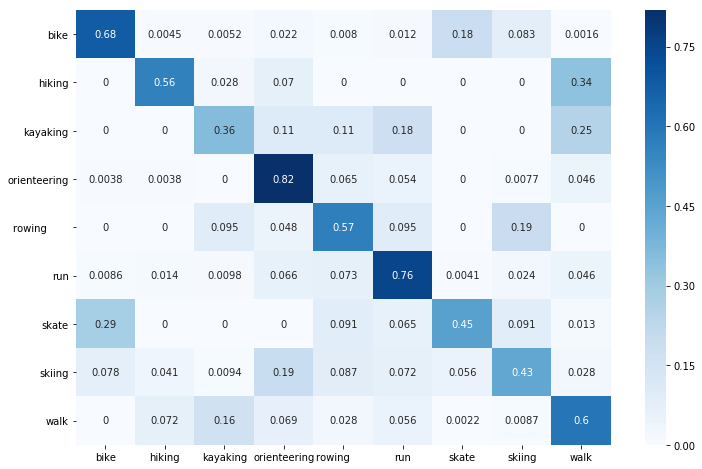

In [40]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = logreg.predict(X_test)
df_pred['lr'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

# y_pred = logreg.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_) 

### KNN Model

In [41]:
# init model

knn = KNeighborsClassifier(n_neighbors=3)

In [42]:
# perform cross validation

score = cross_val_score(knn,X,y,cv=5)
print('score:',score.mean(),score)

score: 0.9592875165157284 [0.96320587 0.95832832 0.96030815 0.96030695 0.95428829]


In [43]:
# fit model

knn.fit(X_train, y_train)

# score model
print("train r2:",knn.score(X_train, y_train))
print("test r2:",knn.score(X_test, y_test))

train r2: 0.989051282051282
test r2: 0.915346038114343


rows:actual columns:predicted


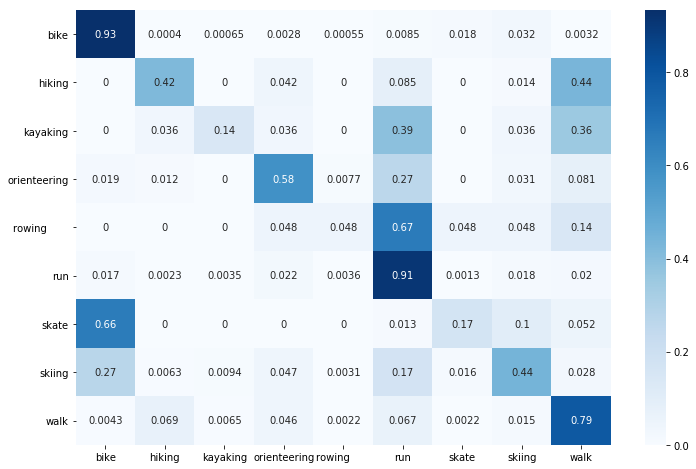

In [44]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = knn.predict(X_test)
df_pred['knn'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

# y_pred = knn.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

### DTC Model

In [45]:
# init model

dtc = DecisionTreeClassifier(max_depth=10,random_state=3050)

In [46]:
# perform cross validation

score = cross_val_score(dtc,X,y,cv=5)
print(score.mean(),score)

0.9616526616238683 [0.96428894 0.96163798 0.96184286 0.96292507 0.95756846]


In [47]:
# fit model
dtc = dtc.fit(X_train,y_train)

# score model
print("train r2:",dtc.score(X_train, y_train))
print("test r2:",dtc.score(X_test, y_test))

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

train r2: 0.8835982905982906
test r2: 0.7715346038114343


rows:actual columns:predicted


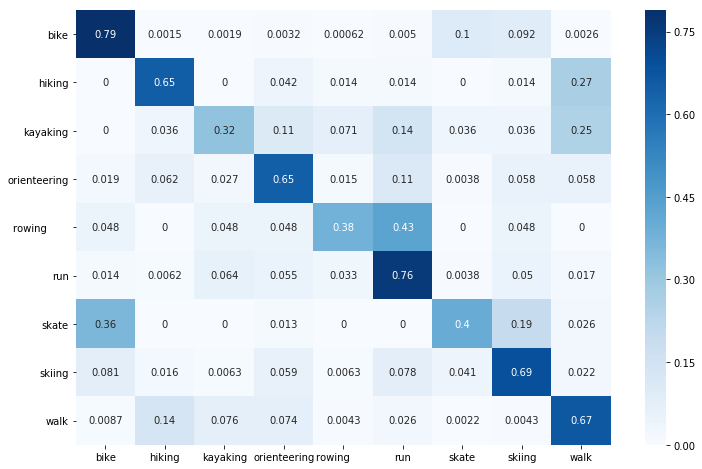

In [48]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = dtc.predict(X_test)
df_pred['dtc'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# y_pred = dtc.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

In [49]:
# # initialize the output file object
# dot_data = StringIO() 

# # my fit DecisionTreeRegressor object here is: dtr1
# # for feature_names i put the columns of my Xr matrix
# export_graphviz(dtc, 
#                 out_file=dot_data,  
#                 filled=True, 
#                 rounded=True,
#                 special_characters=True,
#                 feature_names=df_model[features].columns
#                )  

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### RFC Model

In [50]:
# init model

rfc = RandomForestClassifier(n_estimators=10,max_depth=10,n_jobs=2, random_state=3050)

In [51]:
# perform cross validation

score = cross_val_score(rfc,X,y,cv=5)
print(score.mean(),score)

0.9645173178517444 [0.96645507 0.96419545 0.96437062 0.96566356 0.9619019 ]


In [52]:
# fit model
rfc = rfc.fit(X_train,y_train)

# score model
print("train r2:",rfc.score(X_train, y_train))
print("test r2:",rfc.score(X_test, y_test))

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

train r2: 0.9207008547008547
test r2: 0.8635105315947843


rows:actual columns:predicted


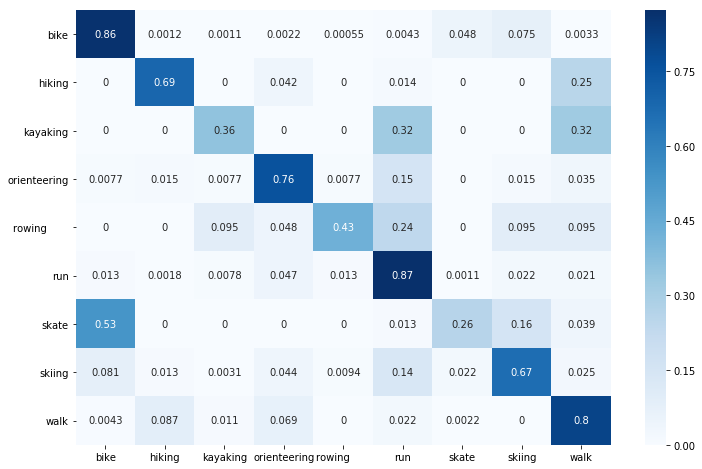

In [53]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = rfc.predict(X_test)
df_pred['rfc'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# y_pred = rfc.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

### SVC Model

In [54]:
# init model

svc = SVC()

In [55]:
# fit model

svc.fit(X_train, y_train)

# score model
print("train r2:",svc.score(X_train, y_train))
print("test r2:",svc.score(X_test, y_test))

train r2: 0.7822564102564102
test r2: 0.7517151454363089


rows:actual columns:predicted


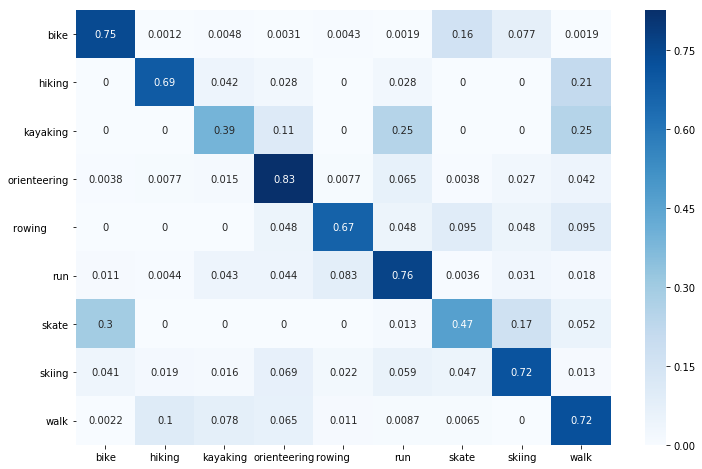

In [56]:
# confusion matrix
print('rows:actual columns:predicted')

y_pred = svc.predict(X_test)
df_pred['svc'] = y_pred

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

# cohen_score = cohen_kappa_score(y_test, y_pred)
# print('cohen_score',cohen_score)

# y_pred = logreg.predict_proba(X_test)
# pd.DataFrame(y_pred,columns=le.classes_)

### Combine Model Predictions

In [57]:
# check predictions

print(df_pred.shape)
df_pred.head()

(49850, 5)


,lr,knn,dtc,rfc,svc
0,6,0,7,7,7
1,0,0,0,0,0
2,7,0,7,7,0
3,0,0,0,0,0
4,5,5,5,5,5


In [58]:
cols = ['svc','rfc','dtc','lr','knn']
df_pred = df_pred[cols]

df_pred_mode = df_pred.mode(axis=1)
df_pred_mode.reset_index(inplace=True)

df_pred_final = df_pred_mode[0]

In [59]:
for idx,row in df_pred_mode.iterrows():
    
    if np.isnan(row[1]) == False:

        mode_list = list(row[1:])
        #print(mode_list)
        
        pred_row = df_pred.iloc[idx,:]
        #print(pred_row)
        
        
        for idx_2,cell in pred_row.iteritems():
            
            if cell in mode_list:
                #print(idx,idx_2,cell)
                df_pred_final[idx] = cell
                break

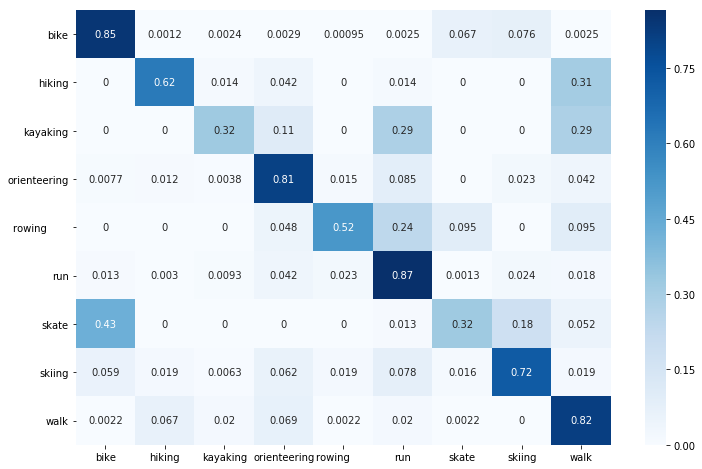

In [60]:
y_pred_final = df_pred_final.values

cm = confusion_matrix(y_test, y_pred_final)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data=cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(12,8))
sns.heatmap(df_cm,annot=True,cmap="Blues");

### GridSearch Model

In [61]:
# init models

estimators = {
    'lr': LogisticRegression(),
    'knn': KNeighborsClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'abc': AdaBoostClassifier(),
    'gbc': GradientBoostingClassifier()
}.items()

In [62]:
# init model parameters

params = {
    'lr': {

    },
    'knn': {
        'knn__n_neighbors': [3,5,7,9]
    },

    'dtc': {
        'dtc__max_features': ['auto', 'log2', None],
        'dtc__max_depth': [None, 5, 10, 15],
        'dtc__min_samples_split': np.linspace(0.1, 0.5, 5)
    },
    'rfc': {
        'rfc__n_estimators': [10, 20, 50, 100],
        'rfc__max_depth': [None, 5, 10, 15],
        'rfc__max_features': ['auto', 'log2', None],
        'rfc__min_samples_split': np.linspace(0.1, 0.5, 5)
    },
    'abc': {

    }, 
    'gbc': {

    }
}

In [63]:
models = []
parameters = []
best_score = []
roc_auc = []

for k,v in estimators:
    
    pipe = Pipeline([
        ('sc', StandardScaler()),
        (k,v)])
    
    gridsearch = GridSearchCV(
        estimator=pipe,
        param_grid=params[k],
        verbose=1,
        cv= 5,
        n_jobs=-1,
        return_train_score= True
        #scoring = 'roc_auc'
    )

    gridsearch.fit(X_train, y_train)
    
    model = gridsearch.best_estimator_
    cv_score = gridsearch.cv_results_
    best_params = gridsearch.best_params_

    # predict y
    #y_pred = model.predict(X_test)
    y_pred = model.predict_proba(X_test)
    
    # print results
    print("Model: ", k)
    print("Best parameters:", best_params)
    print("Best score:", gridsearch.best_score_)
    #print("AUC/ROC test:", roc_auc_score(y_test,y_pred))
    display(pd.DataFrame(cv_score, columns = cv_score.keys()))    
    
    # append info to list
    models.append(k)
    best_score.append(gridsearch.best_score_)
    parameters.append(best_params)
    #roc_auc.append(roc_auc_score(y_test,y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


Model:  lr
Best parameters: {}
Best score: 0.5737777777777778


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.798958,0.755677,0.012496,0.006248,{},0.566453,0.570641,0.576111,0.579017,0.576667,0.573778,0.004577,1,0.575192,0.574765,0.572051,0.573643,0.573194,0.573769,0.001124


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   45.2s finished


Model:  knn
Best parameters: {'knn__n_neighbors': 3}
Best score: 0.9808290598290599


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.354711,0.023440,1.676702,0.018117,3,{'knn__n_neighbors': 3},0.981496,0.982393,0.979786,0.979658,...,0.980829,0.001034,1,0.987479,0.987521,0.987874,0.987799,0.987810,0.987697,0.000163
1,0.307521,0.029285,1.694842,0.060646,5,{'knn__n_neighbors': 5},0.975940,0.977436,0.974060,0.974615,...,0.975530,0.001166,2,0.981197,0.980716,0.981442,0.981432,0.981100,0.981177,0.000266
2,0.289995,0.016288,1.721443,0.049377,7,{'knn__n_neighbors': 7},0.970513,0.971923,0.970085,0.969359,...,0.970538,0.000847,3,0.975598,0.975011,0.975929,0.976058,0.975491,0.975618,0.000368
3,0.278061,0.011691,1.800488,0.062694,9,{'knn__n_neighbors': 9},0.966368,0.967179,0.966111,0.964530,...,0.966162,0.000890,4,0.970598,0.970716,0.970823,0.971335,0.970812,0.970857,0.000253


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.8s finished


Model:  dtc
Best parameters: {'dtc__max_depth': None, 'dtc__max_features': None, 'dtc__min_samples_split': 0.1}
Best score: 0.5841709401709402


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtc__max_depth,param_dtc__max_features,param_dtc__min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.250358,0.010036,0.007142,6.213940e-03,None,auto,0.1,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.512692,0.534231,...,0.529513,0.022201,12,0.514327,0.534241,0.541560,0.495011,0.565011,0.530030,0.023863
1,0.203318,0.008978,0.013361,2.767692e-03,None,auto,0.2,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.481068,0.420769,...,0.459188,0.032622,19,0.483440,0.422543,0.462735,0.422895,0.502137,0.458750,0.031951
2,0.177366,0.011056,0.012650,1.193561e-02,None,auto,0.3,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.355128,0.421667,...,0.375103,0.023701,30,0.350395,0.423932,0.366004,0.365855,0.366709,0.374579,0.025425
3,0.165588,0.012498,0.012496,6.247902e-03,None,auto,0.4,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.352521,0.308632,...,0.314205,0.020068,48,0.354669,0.305118,0.304840,0.291912,0.310855,0.313479,0.021509
4,0.155662,0.011269,0.012496,6.248164e-03,None,auto,0.5,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.262906,0.319060,...,0.276342,0.041159,57,0.261603,0.318953,0.324412,0.210833,0.261197,0.275400,0.042095
5,0.233717,0.009421,0.012497,6.248427e-03,None,log2,0.1,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.561325,0.563504,...,0.549991,0.017938,5,0.566998,0.564573,0.521378,0.537019,0.567158,0.551425,0.018832
6,0.190671,0.008773,0.009372,7.652242e-03,None,log2,0.2,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.523718,0.444915,...,0.477393,0.030318,18,0.525652,0.446955,0.497457,0.473835,0.440395,0.476859,0.031743
7,0.174846,0.008329,0.009373,7.652748e-03,None,log2,0.3,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.382607,0.391538,...,0.369342,0.027837,34,0.387094,0.393077,0.312991,0.361154,0.392286,0.369321,0.030487
8,0.168314,0.020076,0.008043,7.001066e-03,None,log2,0.4,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.343291,0.350983,...,0.320325,0.023989,38,0.345577,0.350994,0.285940,0.308835,0.309712,0.320212,0.024516
9,0.165258,0.011983,0.009582,7.402707e-03,None,log2,0.5,"{'dtc__max_depth': None, 'dtc__max_features': ...",0.309145,0.291795,...,0.272658,0.029496,59,0.309113,0.291261,0.277297,0.261741,0.219882,0.271859,0.030324


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 26.7min finished


Model:  rfc
Best parameters: {'rfc__max_depth': None, 'rfc__max_features': 'log2', 'rfc__min_samples_split': 0.1, 'rfc__n_estimators': 100}
Best score: 0.6572905982905983


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__max_features,param_rfc__min_samples_split,param_rfc__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.059601,0.014690,0.059361,0.006248,None,auto,0.1,10,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.616966,...,0.638641,0.012546,22,0.623654,0.639647,0.634498,0.649733,0.643024,0.638111,0.008759
1,1.917538,0.048756,0.101744,0.008292,None,auto,0.1,20,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.634615,...,0.637231,0.007287,24,0.637895,0.631549,0.636838,0.643793,0.640363,0.638088,0.004052
2,4.695044,0.054490,0.252706,0.011257,None,auto,0.1,50,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.655427,...,0.649684,0.008644,12,0.659915,0.658216,0.647468,0.629380,0.651068,0.649209,0.010912
3,9.698591,0.517269,0.580152,0.018129,None,auto,0.1,100,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.649658,...,0.652701,0.010326,6,0.654006,0.638483,0.656474,0.661421,0.654605,0.652998,0.007711
4,0.934448,0.043667,0.069828,0.012781,None,auto,0.2,10,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.528162,...,0.526427,0.023164,78,0.530556,0.517190,0.494402,0.562575,0.532382,0.527421,0.022204
5,1.764909,0.072027,0.113045,0.011592,None,auto,0.2,20,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.554060,...,0.543949,0.014812,72,0.556079,0.551987,0.562553,0.513942,0.535299,0.543972,0.017511
6,4.163566,0.188480,0.301101,0.018337,None,auto,0.2,50,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.565940,...,0.563957,0.005271,46,0.566293,0.568013,0.562361,0.571848,0.556944,0.565092,0.005088
7,8.175728,0.093004,0.592477,0.063256,None,auto,0.2,100,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.576581,...,0.564376,0.010873,44,0.577030,0.564712,0.560021,0.573504,0.548697,0.564793,0.010075
8,0.784442,0.048503,0.068888,0.007910,None,auto,0.3,10,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.461624,...,0.473769,0.011083,116,0.458910,0.494882,0.476870,0.460021,0.476004,0.473338,0.013185
9,1.451123,0.075499,0.115597,0.012497,None,auto,0.3,20,"{'rfc__max_depth': None, 'rfc__max_features': ...",0.469701,...,0.492145,0.019051,97,0.467297,0.514135,0.472959,0.498248,0.507190,0.491966,0.018614


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.6s finished


Model:  abc
Best parameters: {}
Best score: 0.4060940170940171


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.42929,1.036165,0.706075,0.095501,{},0.384829,0.431795,0.369701,0.461923,0.382222,0.406094,0.034997,1,0.386218,0.435118,0.373579,0.462874,0.378291,0.407216,0.035455


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Model:  gbc
Best parameters: {}
Best score: 0.9092307692307692


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,189.58143,47.186181,0.540493,0.112049,{},0.906581,0.911368,0.909231,0.907863,0.911111,0.909231,0.001843,1,0.911741,0.913034,0.912329,0.912415,0.914274,0.912759,0.000861
